# 2.8- Sequencing data and time series analysis

### Learning goals for today
1. Load, visualize and understand RNA sequencing data
2. Annotating scRNAseq data using marker genes
3. Bonus: Analyzing time series data

---
### How to use this notebook during class
- Follow along as we go
- Use your **Cards** to indicate where you're at:
    - A **🟩Green card** means you are caught up with Max and **ready to help your classmates**
    - A **🟥Red card** means you are stuck and need help
- <span style='color:red;'>EXERCISE</span> — work on this problem by yourself, or try with a partner if you get stuck
---


First let's import some libraries we will use today. Remember if you don't have a library installed you can pip install it with:

%pip install *package_name*

## 1) scRNAseq data - looking at it

Download `tags.csv` and `ct.csv` from brightspace or the course github

Data originally from: https://www.pnas.org/doi/full/10.1073/pnas.1507125112



In [1]:
%pip install scanpy
%pip install igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 21.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.5 MB/s eta 0:00:00
  Attempting uninstall: statsmodels91m╸━━━━━━━━━━━━━━━━━━  7/13 [zarr]
    Found existing installation: statsmodels 0.14.4━━━━━━━━━━━  7/13 [zarr]
    Uninstalling statsmodels-0.14.4:╸━━━━━━━━━━━━━━━  8/13 [statsmodels]
      Successfully uninstalled statsmodels-0.14.4━━━━━━━━━━━━━  8/13 [statsmodels]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [scanpy]12/13 [scanpy]cent]
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [igraph]
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import scanpy 
import anndata

Generally it is best to not keep data in your code repository, and GitHub cannot sync large files. So let's point our code to the file path on the computer

In [7]:
data_directory = '/Users/parmeshthakoordial/Desktop/PythonFiles'
filepath_tags = os.path.join(data_directory, 'tags.csv')
filepath_celltypes = os.path.join(data_directory, 'ct.csv')

os.path.exists(filepath_celltypes)

True

First we'll use pandas to load the data. There are two things we'll load:
1. The gene counts matrix, which has cells along the rows and genes along the columns
2. The cell type array, which has labels for each annotated cell type 

In [8]:
reads_df = pd.read_csv(filepath_tags, index_col=0).T
reads_df.head()

,1/2-SBSRNA4,A1BG,A1BG-AS1,A1CF,A2LD1,A2M,A2ML1,A2MP1,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,tAKR
GSM1658365,0,0,0,0,0,0,0,0,0,0,...,0,28,0,5,0,67,9,0,0,0
GSM1658366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,22,0,0,6,0,7,0
GSM1658364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
GSM1658363,0,0,0,0,0,0,0,0,0,0,...,0,0,0,18,0,0,0,0,4,0
GSM1658362,0,0,0,0,0,0,0,0,0,0,...,0,0,0,8,0,0,0,0,0,0


These data have already been annotated. Let's look at the cell types in the annotation

In [13]:
cell_types = pd.read_csv(filepath_celltypes, index_col=0)
cell_types.value_counts()

cell_type        
neurons              131
fetal_quiescent      110
astrocytes            62
oligodendrocytes      38
fetal_replicating     25
endothelial           20
OPC                   18
microglia             16
Name: count, dtype: int64

This is a big matrix, and scanpy uses a special data type to hold this and run calcuations on it called an Annotated Data (AnnData) object

Let's make an AnnData (Annotated Data) object from our two dataframes

In [14]:
adata = anndata.AnnData(reads_df, obs=cell_types)
print(adata)

AnnData object with n_obs × n_vars = 420 × 22085
    obs: 'cell_type'


Let's do some standard preprocessing steps to remove cells that don't have many genes, and genes that don't show up in many cells

In [15]:
scanpy.pp.filter_cells(adata, min_genes=100)
scanpy.pp.filter_genes(adata, min_cells=3)

print(adata)

AnnData object with n_obs × n_vars = 420 × 19231
    obs: 'cell_type', 'n_genes'
    var: 'n_cells'


Notice that when we do stuff to adata, it modifies the object **in place** and adds new observations to the table

The next step is to normalize the read counts within a cell to that cell's median reads. That lets us compare amount of gene expression across cells that maybe just have more mRNA around for whatever reason.

Then we'll transform to log(count+1). Log transforming helps make the variances more comparable for genes that may differ in abundance over orders of magnitude. 

In [16]:
# median count depth normalization 
scanpy.pp.normalize_total(adata)

scanpy.pp.log1p(adata)
adata

AnnData object with n_obs × n_vars = 420 × 19231
    obs: 'cell_type', 'n_genes'
    var: 'n_cells'
    uns: 'log1p'

**Feature selection:** Let's add tags to indicate "highly variable genes," to help us focus on genes that are differentially expressed across the cells. We will use this for visualizing lower dimensional representations (like UMAP) and for clustering

In [19]:
scanpy.pp.highly_variable_genes(adata, n_top_genes=2000)
adata

AnnData object with n_obs × n_vars = 420 × 19231
    obs: 'cell_type', 'n_genes'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

Let's do PCA to get a sense of the dimensionality of the data

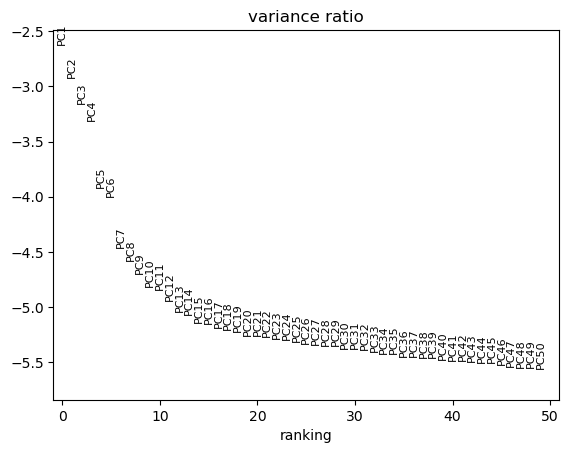

In [26]:
scanpy.tl.pca(adata)
scanpy.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

Let's look at a lower dimensional representation of the gene expression profiles of these cells using UMAP. We will use pre-annotated cell types to color the points

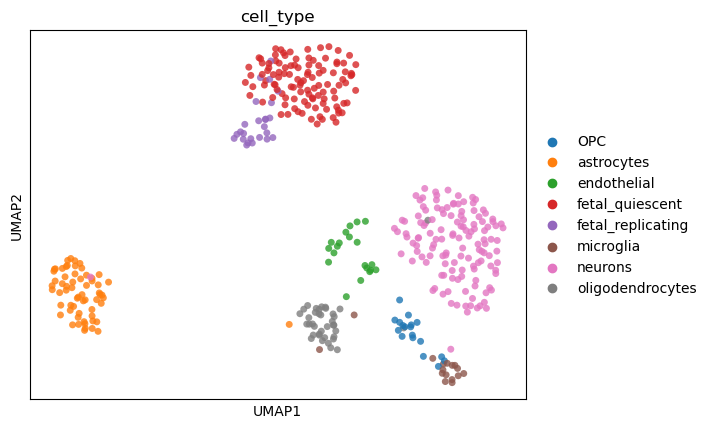

In [31]:
# compute neighborhood graph (distance matrix) 
scanpy.pp.neighbors(adata)

# project data into heatmap coordinates 
scanpy.tl.umap(adata)

#display UMAP
scanpy.pl.umap(adata, color='cell_type', size=100, alpha=0.8)

## 2) scRNAseq data - clustering and annotating
What if we didn't have cell type annotations? Let's see how we could make our own using clustering and known marker genes


Now let's cluster our cells using the Leiden method. We can control how fine-scale the clustering is with the `resolution` parameter.

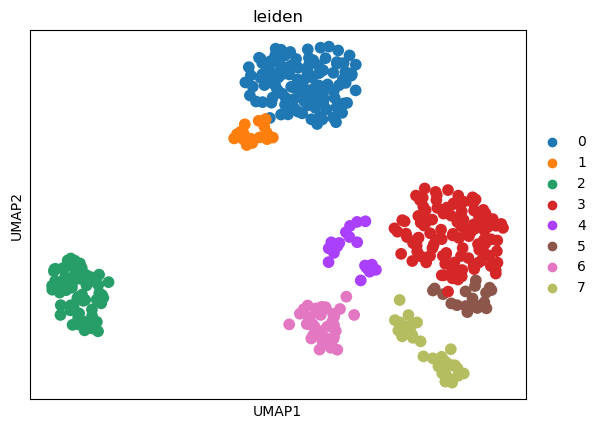

In [43]:
scanpy.tl.leiden(adata, flavor='igraph', resolution=0.90)
scanpy.pl.umap(adata,color='leiden')

### <span style='color:red;'>EXERCISE 1</span>: Find a good resolution value  (5 min)

Play with the `resolution` parameter to find a good value that gives use approximately the right number of clusters. You can iterate on this while trying to assign clusters to cell types


Suppose we have marker genes for each of the cell types we are interested in. We can tell scanpy about these marker genes using a dictionary like this one:

In [45]:
marker_genes_dict = {
    "OPC": ["PCDH15", "MEGF11", "LHFPL3", "PDGFRA"],
    "Astrocytes": ["SLC14A1", "GLIS3", "GLI3", "CTH", "HGF"],
    "Endothelial": ["APOLD1", "FLT1", "A2M", "TM4SF1"],
    "microglia": ["CCL4", "GPR183", "CD83", "CD14", "CSF1R"],
    "neurons": ["KCNK1", "NELL1", "COBL", "DCN", "DLX2", "DLX5", "SST", "PNOC"],
    "oligodendrocytes": ["DAAM2", "ASPA", "MAL", "MAG", "GSN"],
}

Now let's see how our clusters line up to real cell types using a dotplot

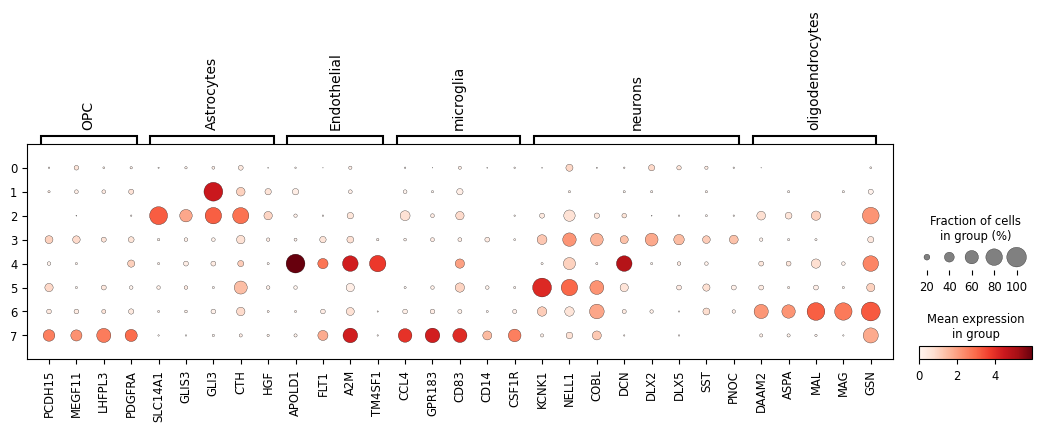

In [46]:
scanpy.pl.dotplot(adata, marker_genes_dict, groupby="leiden")

In [50]:
cluster_mapping_dictionary =     {
                                  "0": "?",
                                  "1": "Endothelial",
                                  "2": "Astrocytes",
                                  "3": "Neurons",
                                  "4": "Oligodendrocytes",
                                  "5": "OPC",
                                 }

Let's add an observation to the andata object to hold our putative cell types. We'll do this using the pandas .map() function on our dictionary

Then we'll look at the UMAP, colored by putative cell type

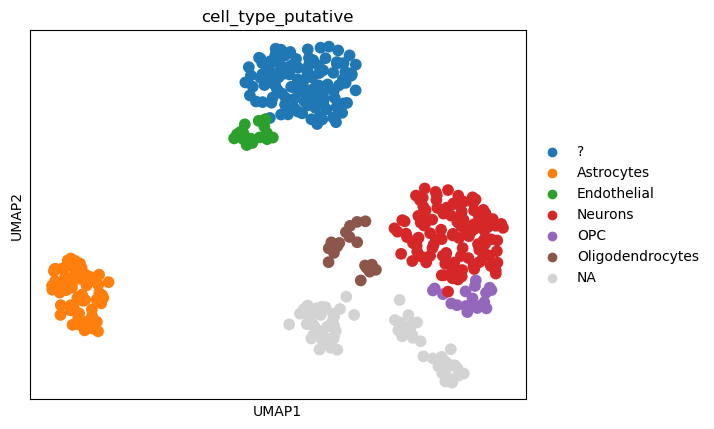

In [57]:
adata.obs['cell_type_putative'] = adata.obs['leiden'].map(cluster_mapping_dictionary)

scanpy.pl.umap(adata, color='cell_type_putative')

You can imagine that for your own data you would want to iterate on clustering, labeling, and identifying marker genes until you are happy with your clusters

Let's take a rough look at differentially expressed genes among these groups

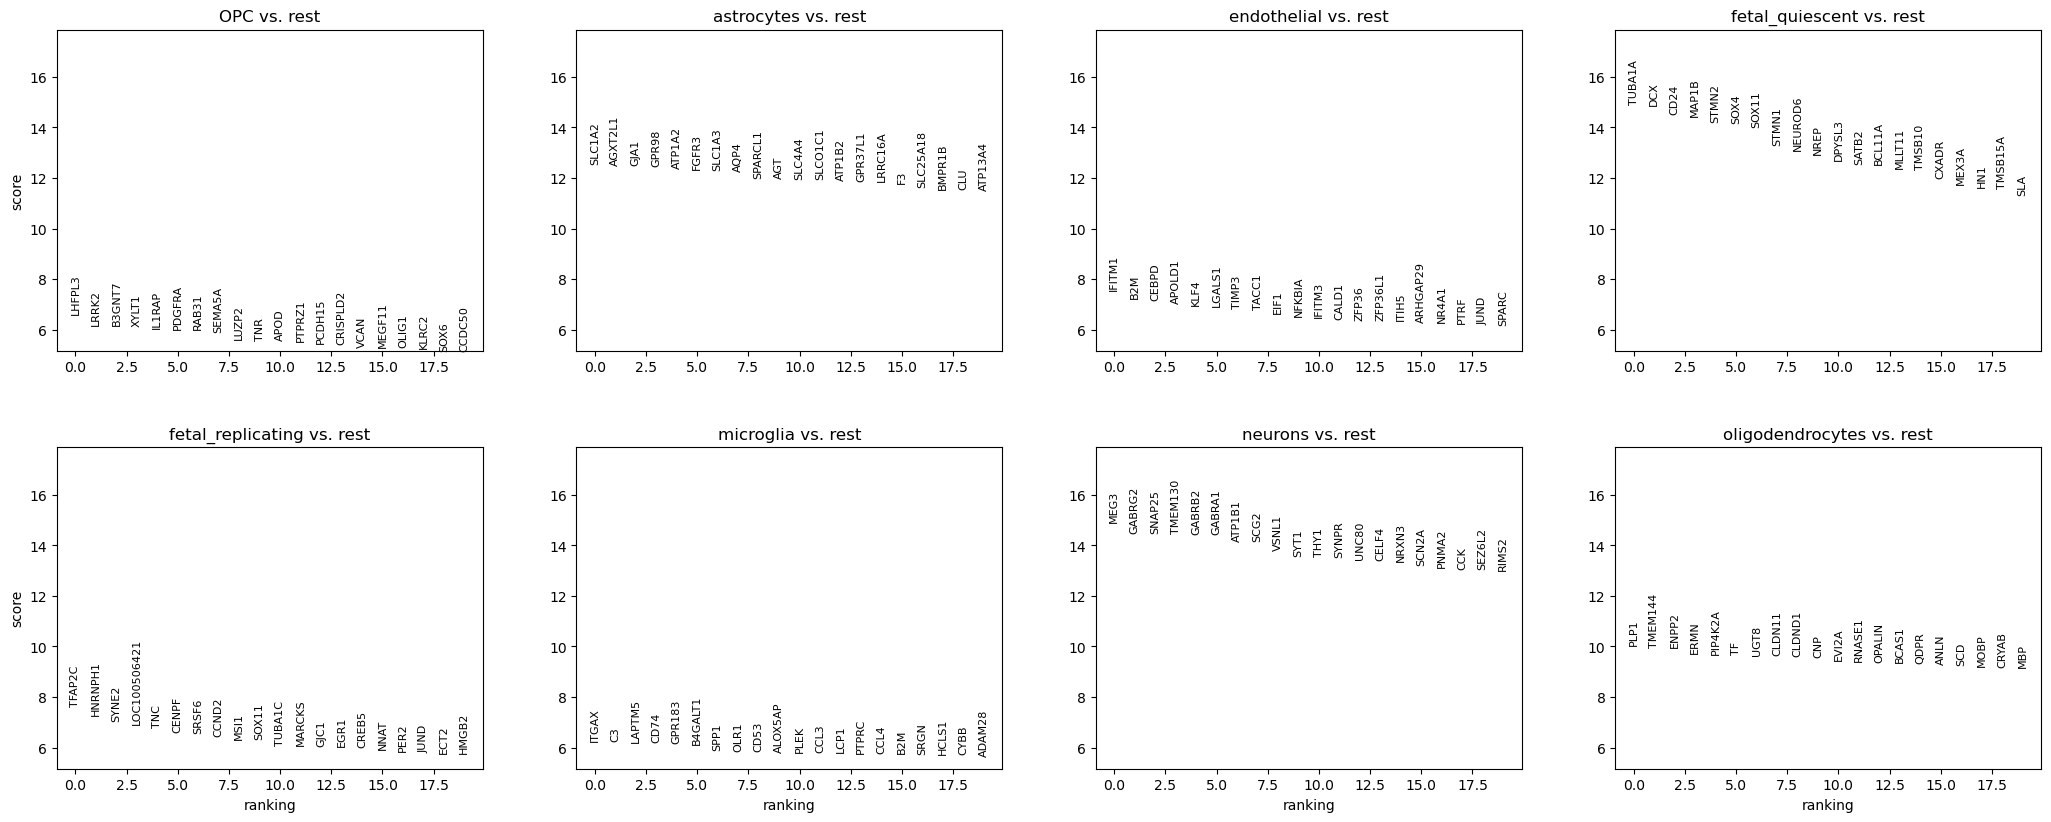

In [59]:
scanpy.tl.rank_genes_groups(adata, "cell_type", method='wilcoxon')
scanpy.pl.rank_genes_groups(adata)

Let's make volcano plot

In [62]:
result = scanpy.get.rank_genes_groups_df(adata, group=['neurons'], pval_cutoff=0.01)
result.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,MEG3,14.894347,7.395569,3.586723e-50,6.897628e-46
1,GABRG2,14.492606,6.931857,1.349250e-47,9.629404e-44
2,SNAP25,14.464840,6.363084,2.020746e-47,9.629404e-44
3,TMEM130,14.461370,6.710864,2.125277e-47,9.629404e-44
4,GABRB2,14.450089,7.585397,2.503615e-47,9.629404e-44


In [64]:
result["-logP"] = -np.log(result["pvals_adj"].astype("float"))
result

,names,scores,logfoldchanges,pvals,pvals_adj,-logP
0,MEG3,14.894347,7.395569,3.586723e-50,6.897628e-46,103.987737
1,GABRG2,14.492606,6.931857,1.349250e-47,9.629404e-44,99.048923
2,SNAP25,14.464840,6.363084,2.020746e-47,9.629404e-44,99.048923
3,TMEM130,14.461370,6.710864,2.125277e-47,9.629404e-44,99.048923
4,GABRB2,14.450089,7.585397,2.503615e-47,9.629404e-44,99.048923
...,...,...,...,...,...,...
4980,HNRNPH1,-8.879514,-1.293640,6.715307e-19,4.035690e-17,37.748769
4981,H3F3B,-9.328544,-1.850932,1.073351e-20,8.256647e-19,41.638098
4982,SCD,-9.388414,-4.282340,6.091006e-21,4.781067e-19,42.184453
4983,NHSL1,-10.308600,-5.798229,6.443250e-25,8.604870e-23,50.807129


Text(0, 0.5, 'log10(p)')

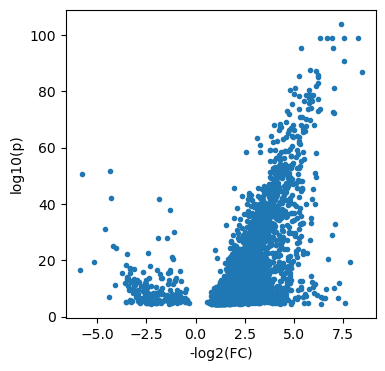

In [65]:
fh, ax = plt.subplots(1,1, figsize=(4,4))
ax.scatter(x=result['logfoldchanges'], 
           y=result['-logP'], 
           marker='.')
ax.set_xlabel('-log2(FC)')
ax.set_ylabel('log10(p)')

# BONUS: time series analysis

## 3) Time series data -  Examining extracellular spiking data

### Detect spike times
Let's say we want to detect the times when the neuron fired an action potential (spike). 

Steps:
1. Filter the signal: remove low-frequency changes in baseline using a **high-pass filter**
2. Find the points where the trace goes beyond some threshold value
3. Make sure you aren't double counting spikes!


## 4) Spike triggered average of a neuron

Reliable spike detection is beyond the scope of this class, so we're going to skip some intervening steps and start with already detected spikes.
A common way to represent spike times is a vector that is zero everywhere except the time points where the spike occurred.

Let's load some processed spike time data, alongside the visual stimulus that was shown to the neuron. These data are from a neuron in blowfly called H1 that is sensitive to motion in the visual world. The stimulus is reported as the rotational velocity (in degrees/second). Both the stimulus and spike times have a sampling period of 2 msec.

`'stim'` is the stimulus

`'rho'` is the spike binary vector

Let's make some variables to be able to refer to each of these a bit more easily. We'll also make a vector of timestamps based on the knowledge that each time step is 2 msec


Now let's jsut plot a bit of the stim and response trace to see what we're looking at

We're going to figure out what makes this neuron spike. To do that we will compute the **spike triggered average stimulus** this, as the name implies is the average stimulus that triggers a spike. The strategy is straightforward:
1. Define some window of time to look backwards (let's say 300 datapoints, or 600 msec)
2. Find all the spike times
3. Pull out the stimulus for the 300 datapoints preceding each spike
4. Average all the stimuli together

Now let's plot our spike triggered average. To visualize it, we need a time vector for the x axis...